In [66]:
import pyriemann
from filenames_and_paths import *
from sklearn.model_selection import cross_val_score
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.linalg import eigh


In [67]:
raw = mne.io.read_raw_brainvision(folders.raw_data + path014 + filenames014[0] + '.vhdr', preload=True)
raw = raw.drop_channels(["EOG", "BIP1", "M1", "M2"])

Extracting parameters from ./raw_data/rest_14/ACP_INP0014_REST1_1pnt_1vis.vhdr...
Setting channel info structure...
Reading 0 ... 1013446  =      0.000 ...   494.847 secs...


In [98]:
# Параметры данных
sfreq = 2048  # Частота дискретизации
time = 20
times = np.arange(0, time, 1/sfreq)  # 180 секунд
n_channels = len(raw.ch_names)  # Количество каналов
n_samples = len(times)
eeg_data = raw.get_data().T[:sfreq*time].T
raw = mne.io.RawArray(eeg_data, raw.info)
raw.filter(1, 40)
print(raw.get_data().shape)

Creating RawArray with float64 data, n_channels=61, n_times=40960
    Range : 0 ... 40959 =      0.000 ...    20.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6759 samples (3.300 s)

(61, 40960)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


## Чистые данные

In [99]:
raw_clean = mne.io.read_raw_eeglab(folders.preprocessed_data + path014 + filenames014[1] + '.set', preload=True)

C:\Users\bortn\AppData\Local\Temp\ipykernel_37284\4202072351.py:1: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_clean = mne.io.read_raw_eeglab(folders.preprocessed_data + path014 + filenames014[1] + '.set', preload=True)


# Шаг 2: Разделение данных на эпохи

In [100]:
events = mne.make_fixed_length_events(raw, id=1, duration=2.0)
epochs = mne.Epochs(raw, events, event_id=1, tmin=0, tmax=2.0, baseline=None, preload=True)

events_clean = mne.make_fixed_length_events(raw_clean, id=1, duration=2.0)
epochs_clean = mne.Epochs(raw_clean, events_clean, event_id=1, tmin=0, tmax=2.0, baseline=None, preload=True)

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 4097 original time points ...
1 bad epochs dropped
Not setting metadata
213 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 213 events and 4097 original time points ...
0 bad epochs dropped


# Шаг 3: Вычисление ковариационных матриц

In [101]:
def calculate_covariances(epochs):
    n_epochs, n_channels, n_samples = epochs.shape
    covariances = np.zeros((n_epochs, n_channels, n_channels))
    for i in range(n_epochs):
        covariances[i] = np.cov(epochs[i])
    return covariances

covariances = calculate_covariances(epochs.get_data())
covariances_clean = calculate_covariances(epochs_clean.get_data())

C:\Users\bortn\AppData\Local\Temp\ipykernel_37284\1883718237.py:8: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  covariances = calculate_covariances(epochs.get_data())
C:\Users\bortn\AppData\Local\Temp\ipykernel_37284\1883718237.py:9: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  covariances_clean = calculate_covariances(epochs_clean.get_data())


# Шаг 4: Обучение Riemannian Potato

In [102]:
covariances.shape

(9, 61, 61)

In [122]:
# from scipy.linalg import eigvalsh, solve
# 
# def _check_inputs(A, B):
#     if not isinstance(A, np.ndarray) or not isinstance(B, np.ndarray):
#         raise ValueError("Inputs must be ndarrays")
#     if not A.shape == B.shape:
#         raise ValueError("Inputs must have equal dimensions")
#     if A.ndim < 2:
#         raise ValueError("Inputs must be at least a 2D ndarray")
# 
# 
# def _recursive(fun, A, B, *args, **kwargs):
#     """Recursive function with two inputs."""
#     if A.ndim == 2:
#         return fun(A, B, *args, **kwargs)
#     else:
#         return np.asarray(
#             [_recursive(fun, a, b, *args, **kwargs) for a, b in zip(A, B)]
#         )
#     
# def distance_riemann(A, B, squared=False):
#     _check_inputs(A, B)
#     d2 = (np.log(_recursive(eigvalsh, A, B))**2).sum(axis=-1)
#     return d2 if squared else np.sqrt(d2)

In [129]:
# Функция для вычисления риманова расстояния
def riemannian_distance(C1, C2):
    eigvals = eigh(C1, C2, eigvals_only=True)
    return np.sqrt(np.sum(np.log(eigvals ** 2)))

def train_potato(covariances, n_train=20):
    mean_cov = np.mean(covariances[:n_train], axis=0)
    distances = np.array([riemannian_distance(mean_cov, cov) for cov in covariances[:n_train]])
    threshold = np.percentile(distances, 95)  # Установим порог на уровне 95-го перцентиля
    return mean_cov, threshold

mean_cov, threshold = train_potato(covariances_clean, n_train=200)

C:\Users\bortn\AppData\Local\Temp\ipykernel_37284\3055890164.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.sum(np.log(eigvals ** 2)))


In [124]:
covariances_clean

array([[[ 1.39521919e-10,  9.77371496e-11,  4.84537931e-11, ...,
         -3.32515528e-11, -5.51859912e-11, -4.22024451e-11],
        [ 9.77371496e-11,  7.85867637e-11,  4.84030360e-11, ...,
         -2.55188247e-11, -4.21971044e-11, -4.64415241e-11],
        [ 4.84537931e-11,  4.84030360e-11,  6.67417495e-11, ...,
         -2.96426498e-11, -2.96835439e-11, -3.79944138e-11],
        ...,
        [-3.32515528e-11, -2.55188247e-11, -2.96426498e-11, ...,
          9.17863617e-11,  4.09198324e-11,  8.25400423e-11],
        [-5.51859912e-11, -4.21971044e-11, -2.96835439e-11, ...,
          4.09198324e-11,  1.12293852e-10,  9.83616714e-11],
        [-4.22024451e-11, -4.64415241e-11, -3.79944138e-11, ...,
          8.25400423e-11,  9.83616714e-11,  2.30240446e-10]],

       [[ 1.34250020e-10,  1.13196302e-10,  8.87569401e-11, ...,
         -2.77985956e-11, -5.60461181e-11, -6.77667955e-11],
        [ 1.13196302e-10,  1.30493459e-10,  1.17636980e-10, ...,
         -2.81732638e-11, -4.57160478e

# Шаг 5: Оценка качества новых данных

In [125]:
def evaluate_potato(covariances, mean_cov, threshold):
    distances = np.array([riemannian_distance(mean_cov, cov) for cov in covariances])
    predictions = distances < threshold
    return predictions, distances

predictions, distances = evaluate_potato(covariances, mean_cov, threshold)

C:\Users\bortn\AppData\Local\Temp\ipykernel_37284\1177699350.py:23: RuntimeWarning: invalid value encountered in log
  d2 = (np.log(_recursive(eigvalsh, A, B))**2).sum(axis=-1)


In [128]:
np.log([-1, 1, 0] ** 2)

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

In [126]:
distances

array([79.76731588, 80.92103609, 79.79555695,         nan,         nan,
               nan, 79.48061717,         nan, 79.36168099])

# Шаг 6: Визуализация результатов

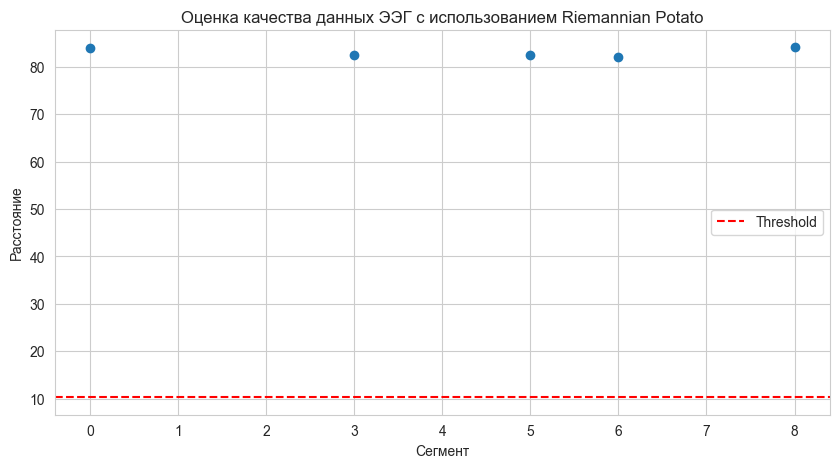

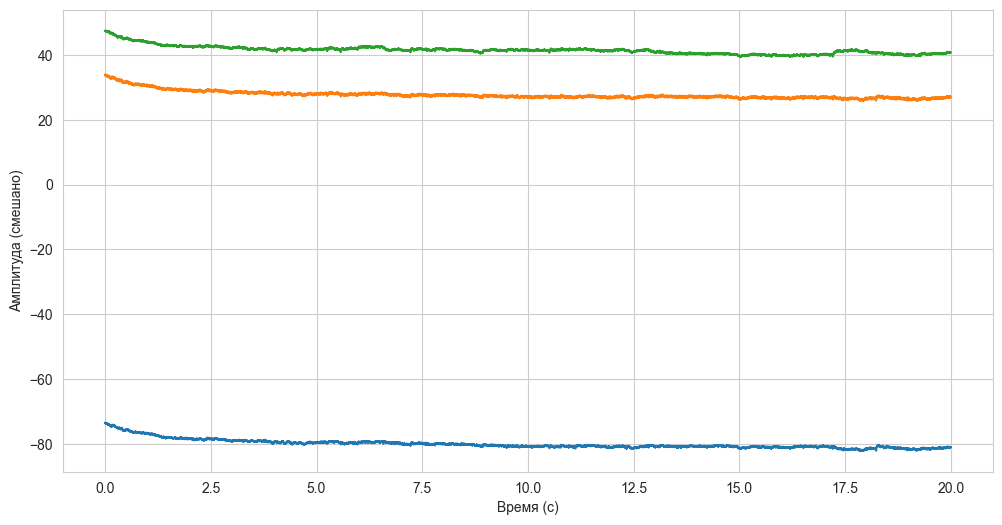

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(distances, 'o')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Сегмент')
plt.ylabel('Расстояние')
plt.title('Оценка качества данных ЭЭГ с использованием Riemannian Potato')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(times, eeg_data[i]*10000 + i, label=f'EEG{i+1}')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда (смешано)')
# plt.legend(loc='upper right')
plt.show()